In [1]:
import dill
import numpy as np
import haiku as hk
import jax.numpy as jnp
import jax
from typing import Callable, Iterable, Optional
import optax
from tqdm import trange
from matplotlib import pyplot as plt
import seaborn as sns
from jax.config import config
from sklearn.metrics import r2_score
import random
#from hyperparam_tuner import *

max_grad_norm = 0.1
n_epochs = 1000
lr = 1e-3
decay = 5e-3
output_size=[500,500,500,276]
activation= jax.nn.leaky_relu
batch_size = 1000

config.update("jax_enable_x64", True)
dtype=jnp.float64

In [2]:
'''
Visualization of hyperparameters
'''
def plot_params(params):
  fig1, axs = plt.subplots(ncols=2, nrows=4)
  fig1.tight_layout()
  fig1.set_figwidth(12)
  fig1.set_figheight(6)
  for row, module in enumerate(sorted(params)):
    ax = axs[row][0]
    sns.heatmap(params[module]["w"], cmap="YlGnBu", ax=ax)
    ax.title.set_text(f"{module}/w")

    ax = axs[row][1]
    b = np.expand_dims(params[module]["b"], axis=0)
    sns.heatmap(b, cmap="YlGnBu", ax=ax)
    ax.title.set_text(f"{module}/b")
  plt.show()

def gradientsVis(grads, modelName = None):
    fig, ax = plt.subplots(2, 1, constrained_layout=True, figsize=(7,5))
    for i, layer in enumerate(sorted(grads)):
        ax[0].scatter(i, grads[layer]['w'].mean())
        ax[0].title.set_text(f'W_grad {modelName}')

        ax[1].scatter(i, grads[layer]['b'].mean())
        ax[1].title.set_text(f'B_grad {modelName}')
    plt.show()
    return fig

In [3]:
'''
Load Train and Test Data
'''
redshift = 5.4 #choose redshift from
num = '6_1000' #choose data number of LHS sampling
# get the appropriate string and pathlength for chosen redshift
zs = np.array([5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0])
z_idx = np.argmin(np.abs(zs - redshift))
z_strings = ['z54', 'z55', 'z56', 'z57', 'z58', 'z59', 'z6']
z_string = z_strings[z_idx]
dir_lhs = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/LHS/'

X = dill.load(open(dir_lhs + f'{z_string}_param{num}.p', 'rb')) # load normalized cosmological parameters from grab_models.py
meanX = X.mean(axis=0)
stdX = X.std(axis=0)
X = (X - meanX) / stdX
X_train = X[:800]
X_test = X[800:]
print(X_train.shape)

Y = dill.load(open(dir_lhs + f'{z_string}_model{num}.p', 'rb'))
meanY = Y.mean(axis=0)
stdY = Y.std(axis=0)
Y = (Y - meanY) / stdY
Y_train = Y[:800]
Y_test = Y[800:]

count = 0
not_eq_count = 0
Real_X_test = []
Real_Y_test = []
for i, test in enumerate(X_test):
    for j, train in enumerate(X_train):
        if np.array_equal(test,train):
            count += 1
            break
        else:
            not_eq_count += 1
    if not_eq_count ==800: 
        Real_X_test.append(test)
        Real_Y_test.append(Y_test[i])
    not_eq_count = 0
            
X_test = jnp.asarray(Real_X_test)
Y_test = jnp.asarray(Real_Y_test)
print(Y_test.shape)


(800, 3)


(84, 276)


In [4]:
'''
Build custom haiku Module
'''
class MyModuleCustom(hk.Module):
  def __init__(self,
               output_size=[100,100,100,276],
               activation: Callable[[jnp.ndarray], jnp.ndarray] = jax.nn.relu,
               activate_final: bool = True,
               dropout_rate: Optional[float] = None,
               name='custom_linear'):
    super().__init__(name=name)
    self.activate_final = activate_final
    self.activation = activation
    self.dropout_rate = dropout_rate
    l = []

    for i, layer in enumerate(output_size):
        z =hk.Linear(output_size=layer, name="linear_%d" % i, w_init = hk.initializers.VarianceScaling(2.0, "fan_avg",  "uniform"))

        l.append(z)
    self.layer = l
    
  def __call__(self, x, rng = 42):
    num_layers = len(self.layer)
    out = x
    rng = hk.PRNGSequence(rng) if rng is not None else None

    for i, layer in enumerate(self.layer):
        out = layer(out)

        if i < (num_layers - 1) or self.activate_final:
            # Only perform dropout if we are activating the output.
            if self.dropout_rate is not None:
                out = hk.dropout(next(rng), self.dropout_rate, out)
            out = self.activation(out)
    print(out.shape)
    return out

def _custom_forward_fn(x):
  module = MyModuleCustom(output_size=output_size, activation = activation)
  return module(x)

custom_forward = hk.without_apply_rng(hk.transform(_custom_forward_fn))
rng_sequence = hk.PRNGSequence(42)
init_params = custom_forward.init(rng=42, x=X_train)
preds = custom_forward.apply(params=init_params, x=X_train)

(800, 276)
(800, 276)


In [36]:
'''
Infrastructure for network training
'''
n_samples = X_train.shape[0]

total_steps = n_epochs*(n_samples//batch_size) + n_epochs

 ###Learning Rate schedule + Gradient Clipping###
def loss_fn(params, x, y):
  return jnp.mean((custom_forward.apply(params, x) - y) ** 2)

@jax.jit
def accuracy(params, x, y):
    preds = custom_forward.apply(params=params, x=x)*stdY+meanY
    y = y*stdY+meanY
    delta = (y - preds) / y
    return delta

schedule_lr = optax.piecewise_constant_schedule(init_value=lr,
                                                boundaries_and_scales={int(total_steps*0.2):0.1,
                                                                        int(total_steps*0.4):0.1,
                                                                       int(total_steps*0.6):0.1,
                                                                       int(total_steps*0.8):0.1})
optimizer = optax.chain(optax.clip_by_global_norm(max_grad_norm),
                        optax.adam(learning_rate=schedule_lr)
                        )
opt_state = optimizer.init(init_params)

@jax.jit
def update(params, opt_state, x, y):
    batch_loss, grads = jax.value_and_grad(loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, batch_loss, grads


(800, 276)


/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

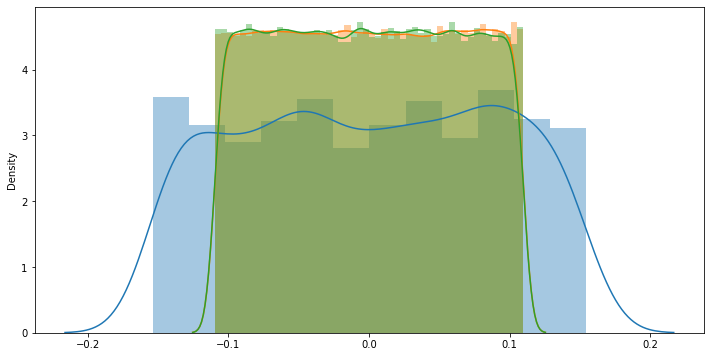

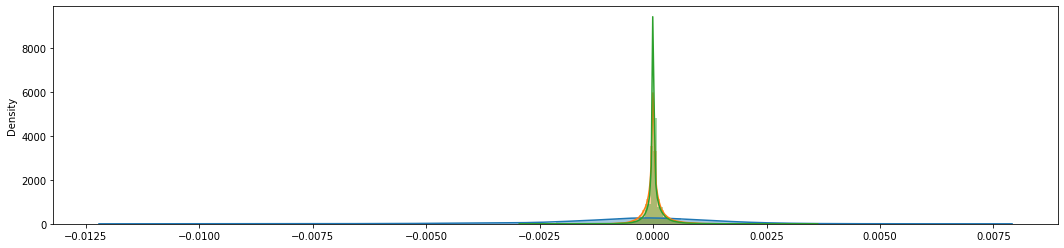

/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zhenyujin/igm_emulator/venv/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level func

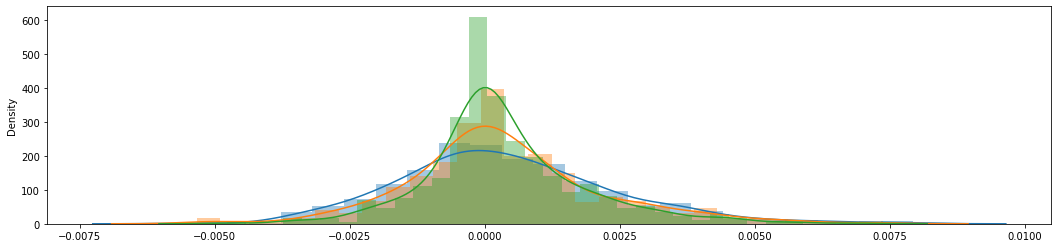

In [37]:
batch_loss, grads = jax.value_and_grad(loss_fn)(init_params, X_train, Y_train)
plt.figure(1,figsize=(12, 6))
sns.distplot(init_params['custom_linear/~/linear_0']['w'])
sns.distplot(init_params['custom_linear/~/linear_1']['w'])
sns.distplot(init_params['custom_linear/~/linear_2']['w'])

plt.figure(2,figsize=(18, 4))
sns.distplot(grads['custom_linear/~/linear_0']['w'])
sns.distplot(grads['custom_linear/~/linear_1']['w'])
sns.distplot(grads['custom_linear/~/linear_2']['w'])
plt.show()

plt.figure(2,figsize=(18, 4))
sns.distplot(grads['custom_linear/~/linear_0']['b'])
sns.distplot(grads['custom_linear/~/linear_1']['b'])
sns.distplot(grads['custom_linear/~/linear_2']['b'])
plt.show()

[[ 0.02234167 -0.03417244  0.05575121 ...  0.1027856   0.08674155
  -0.06239863]
 [ 0.02081907 -0.06723316 -0.08134946 ... -0.09794165 -0.10578416
   0.10670936]
 [ 0.04245441  0.01027981  0.09258659 ... -0.01694078  0.01765975
  -0.05156984]
 ...
 [ 0.00107104  0.06826326 -0.06685141 ... -0.10486043 -0.10524527
  -0.06857163]
 [-0.01557707 -0.1003307   0.05583674 ...  0.10414428  0.02074269
  -0.10929178]
 [ 0.01072051 -0.05327486  0.09702403 ...  0.04234988 -0.03286397
   0.09027007]]


  0%|          | 0/1000 [00:00<?, ?it/s]

(800, 276)


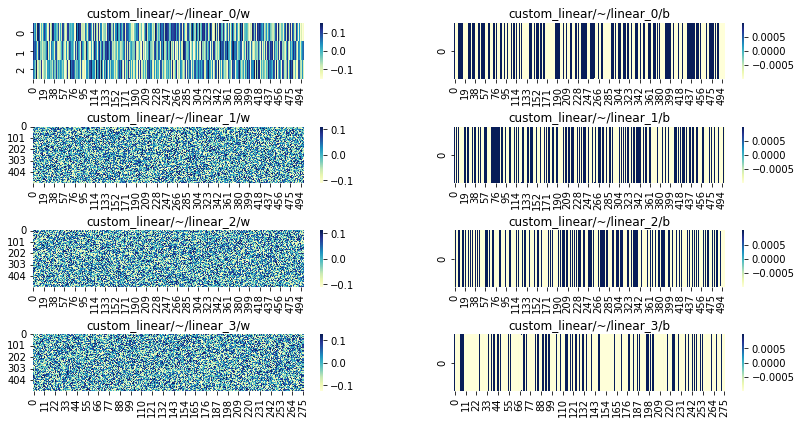

 10%|█         | 100/1000 [00:14<00:39, 22.87it/s, loss=0.004120661169886236]

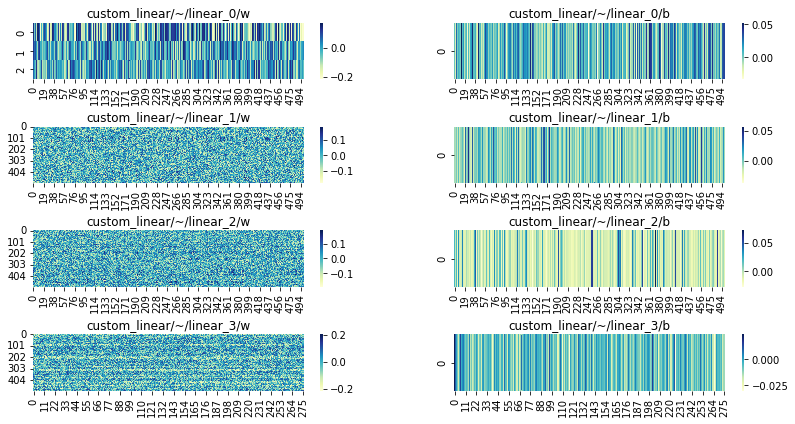

 20%|█▉        | 199/1000 [00:25<00:34, 23.20it/s, loss=0.0027839368966265914]

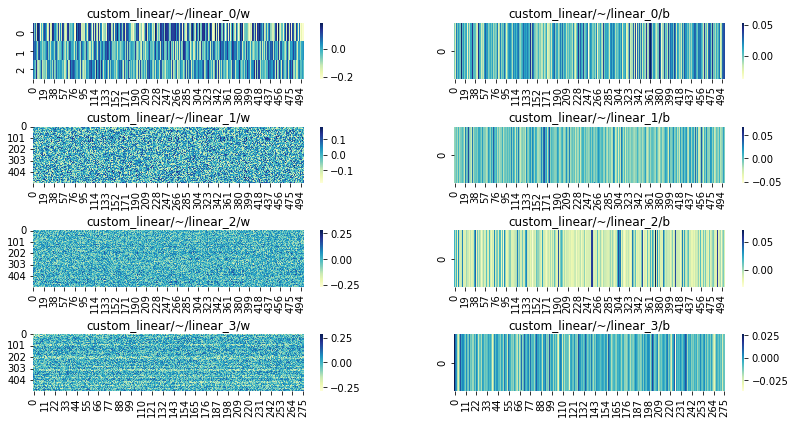

 30%|███       | 300/1000 [00:37<00:36, 19.22it/s, loss=0.0027160193345693736]

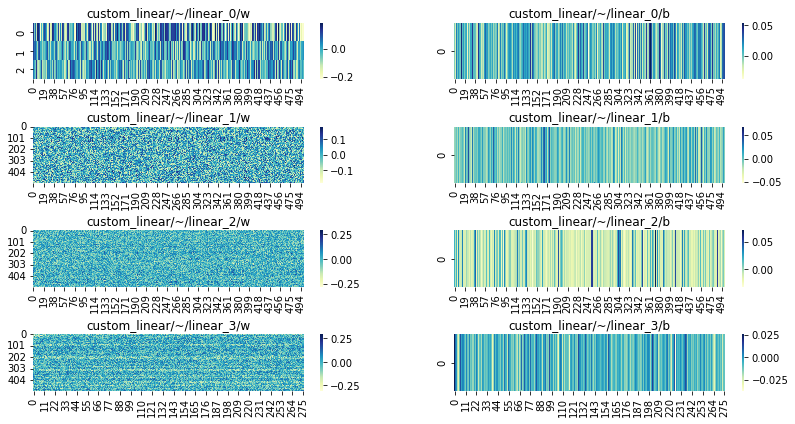

 40%|████      | 400/1000 [00:49<00:30, 19.73it/s, loss=0.0026351723062368305]

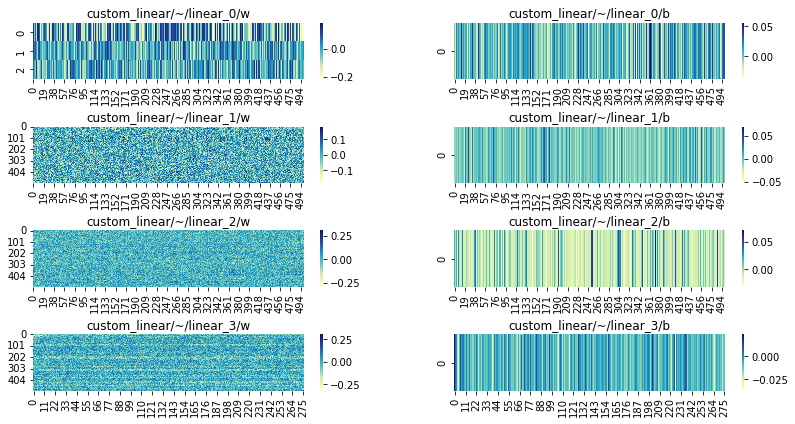

 50%|████▉     | 498/1000 [01:01<00:22, 21.88it/s, loss=0.0026245927769521673]

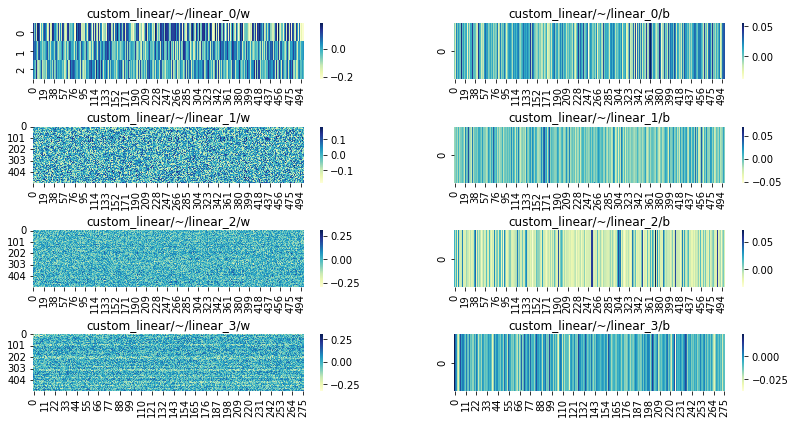

 60%|█████▉    | 598/1000 [01:13<00:19, 20.87it/s, loss=0.002613981420528428] 

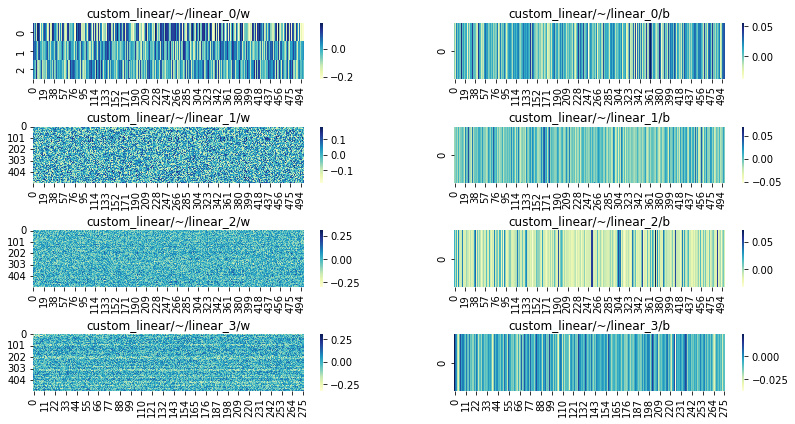

 70%|██████▉   | 699/1000 [01:24<00:13, 22.75it/s, loss=0.002612738369546416] 

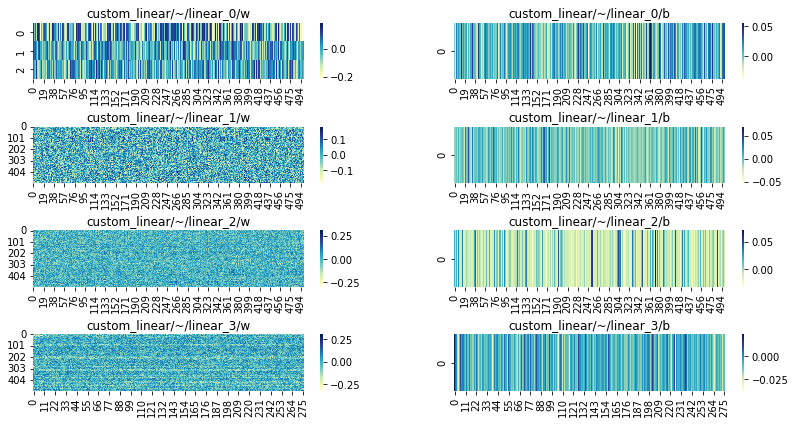

 80%|████████  | 800/1000 [01:36<00:08, 24.13it/s, loss=0.002611523006354566] 

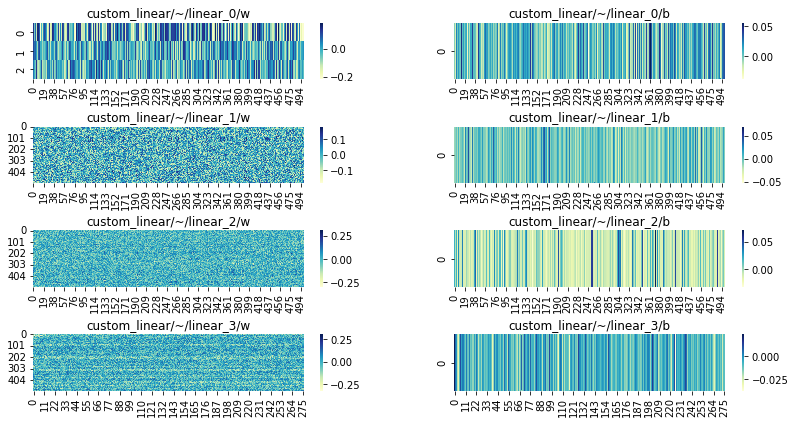

 90%|████████▉ | 899/1000 [01:48<00:04, 22.60it/s, loss=0.002611382995203182] 

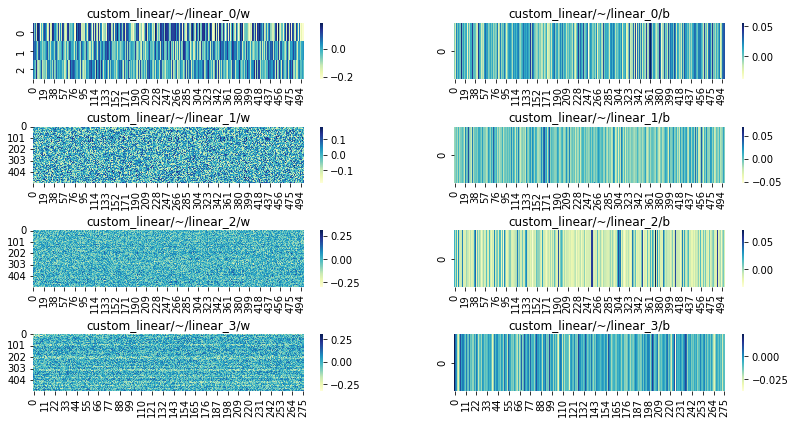

100%|██████████| 1000/1000 [02:00<00:00,  8.29it/s, loss=0.002611247042802178]


Reached max number of epochs in this batch. Loss = 0.002611247042802178
Model saved.
early_stopping_counter: 0
(84, 276)
accuracy: 0.00014876697376341367
(84, 276)
Test Loss: 0.0024194641944462114
(800, 276)


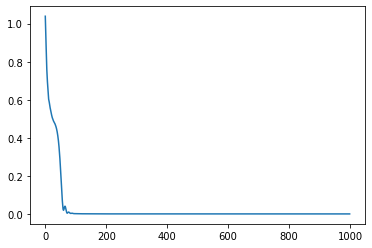

In [38]:
### Random batches of size 200###
idx = [np.random.randint(0,1000,1) for i in range(200)]
### TRAINING loop###
best_loss = np.inf
loss = []
early_stopping_counter = 0
pv = 100
params = init_params
print(params['custom_linear/~/linear_1']['w'])


if __name__ == "__main__":
    with trange(n_epochs) as t:
        for step in t:
                # optimizing loss by update function
            params, opt_state, batch_loss, grads = update(params, opt_state, X_train, Y_train)

            if step % 100 == 0:
                    plot_params(params)
                    #gradientsVis(grads, f'Epoch{step}')
                    #print(f'grads: {grads}')

                # compute validation loss at the end of the epoch
            l = batch_loss
            loss.append(l)

                # update the progressbar
            t.set_postfix(loss=loss[-1])

                # early stopping condition
            if l <= best_loss:
                    best_loss = l
                    early_stopping_counter = 0
            else:
                    early_stopping_counter += 1
            #t.set_postfix(early_stopping_counter=early_stopping_counter) 
            if early_stopping_counter >= pv:
                    break
            
    print('Reached max number of epochs in this batch. Loss = ' + str(best_loss))
    print(f'Model saved.')
    print(f'early_stopping_counter: {early_stopping_counter}')
    print(f'accuracy: {jnp.mean(accuracy(params, X_test, Y_test))}')
    print(f'Test Loss: {loss_fn(params, X_test, Y_test)}')
    plt.plot(range(len(loss)),loss)
    #plt.show()
        # Final trained parameters and resulting prediction
    preds = custom_forward.apply(params=params, x=X_train)

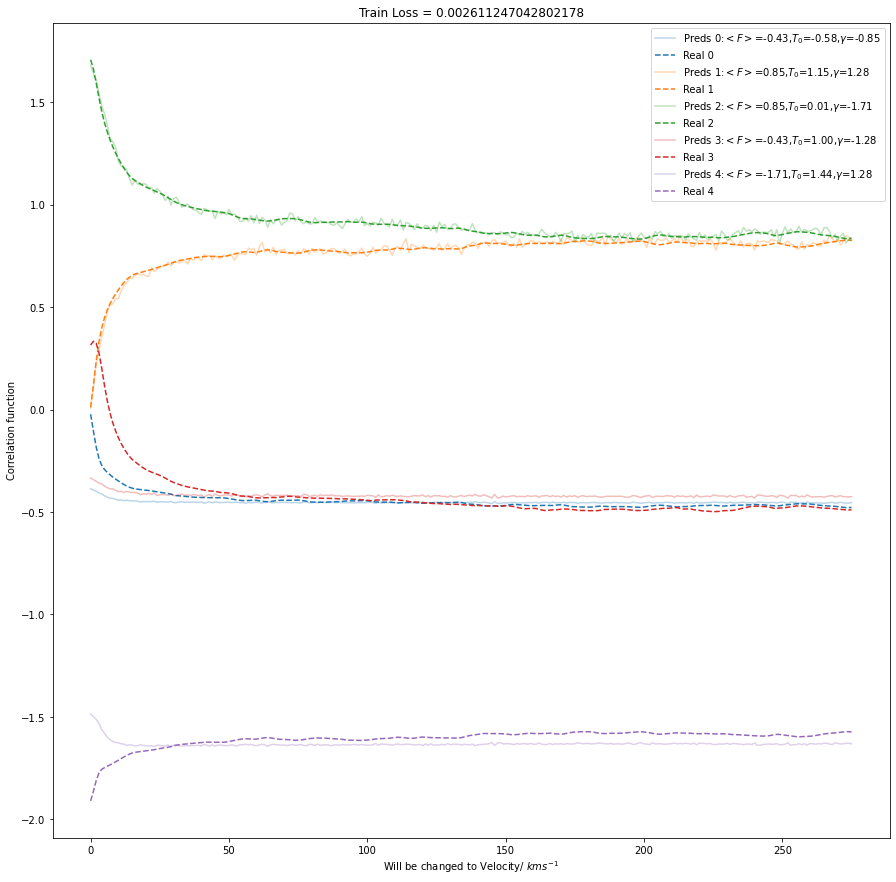

(84, 276)
(84, 276)


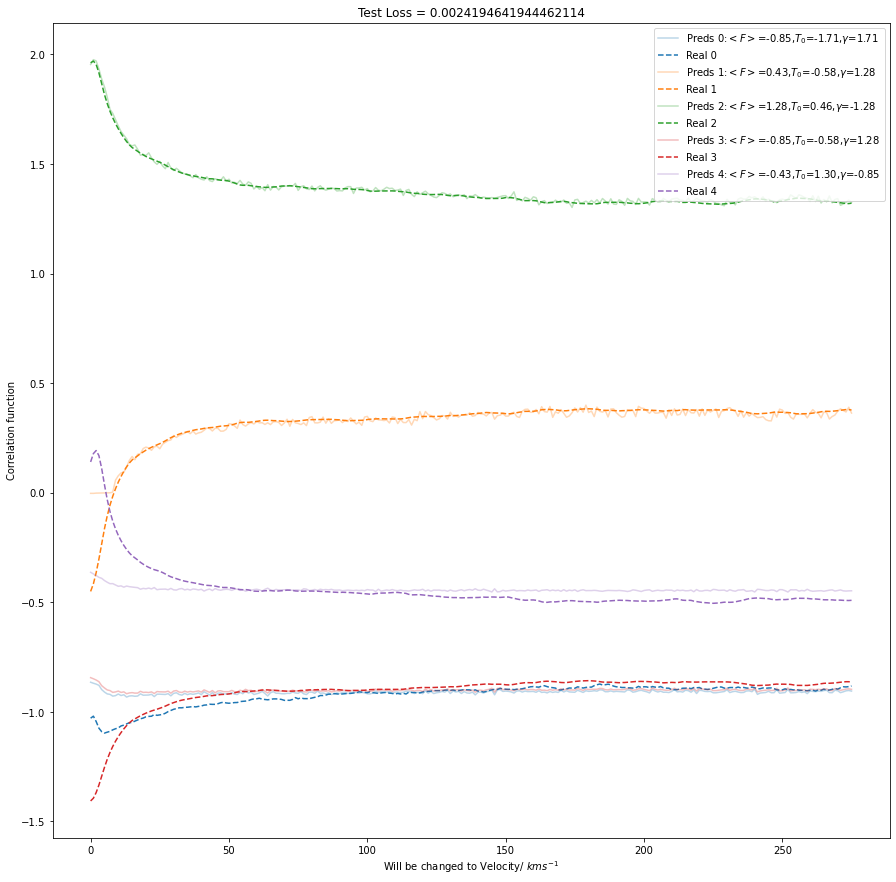

In [45]:
# Plot partial predited corrolation functions and
    ax = np.arange(276)  # arbitrary even spaced x-axis (will be converted to velocityZ)
    sample = 5  # number of functions plotted
    fig, axs = plt.subplots(1, 1)
    fig.set_figwidth(15)
    fig.set_figheight(15)
    corr_idx = np.random.randint(0, 84, sample)  # randomly select correlation functions to compare
    for i in range(sample):
        axs.plot(ax, preds[corr_idx[i]], label=f'Preds {i}:' r'$<F>$='f'{X_train[corr_idx[i], 0]:.2f},'
                                               r'$T_0$='f'{X_train[corr_idx[i], 1]:.2f},'
                                               r'$\gamma$='f'{X_train[corr_idx[i], 2]:.2f}', c=f'C{i}', alpha=0.3)
        axs.plot(ax, Y_train[corr_idx[i]], label=f'Real {i}', c=f'C{i}', linestyle='--')
    # axs.plot(ax, y_mean, label='Y mean', c='k', alpha=0.2)
    plt.xlabel(r'Will be changed to Velocity/ $km s^{-1}$')
    plt.ylabel('Correlation function')
    plt.title(f'Train Loss = {best_loss}')
    plt.legend()
    dir_exp = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/EXP/'  # plot saving directory
    # plt.savefig(os.path.join(dir_exp, f'{self.layers}_overplot{self.comment}.png'))
    plt.show()
    
    test_preds = custom_forward.apply(params, X_test)
    test_loss = loss_fn(params, X_test, Y_test)
    test_R2 = r2_score(test_preds.squeeze(), Y_test)
    
    fig2, axs2 = plt.subplots(1, 1)
    fig2.set_figwidth(15)
    fig2.set_figheight(15)
    for i in range(sample):
        axs2.plot(ax, test_preds[corr_idx[i]], label=f'Preds {i}:' r'$<F>$='f'{X_test[corr_idx[i], 0]:.2f},'
                                               r'$T_0$='f'{X_test[corr_idx[i], 1]:.2f},'
                                               r'$\gamma$='f'{X_test[corr_idx[i], 2]:.2f}', c=f'C{i}', alpha=0.3)
        axs2.plot(ax, Y_test[corr_idx[i]], label=f'Real {i}', c=f'C{i}', linestyle='--')
    # axs.plot(ax, y_mean, label='Y mean', c='k', alpha=0.2)
    plt.xlabel(r'Will be changed to Velocity/ $km s^{-1}$')
    plt.ylabel('Correlation function')
    plt.title(f'Test Loss = {test_loss}')
    plt.legend()
    dir_exp = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/EXP/'  # plot saving directory
    # plt.savefig(os.path.join(dir_exp, f'{self.layers}_overplot{self.comment}.png'))
    plt.show()

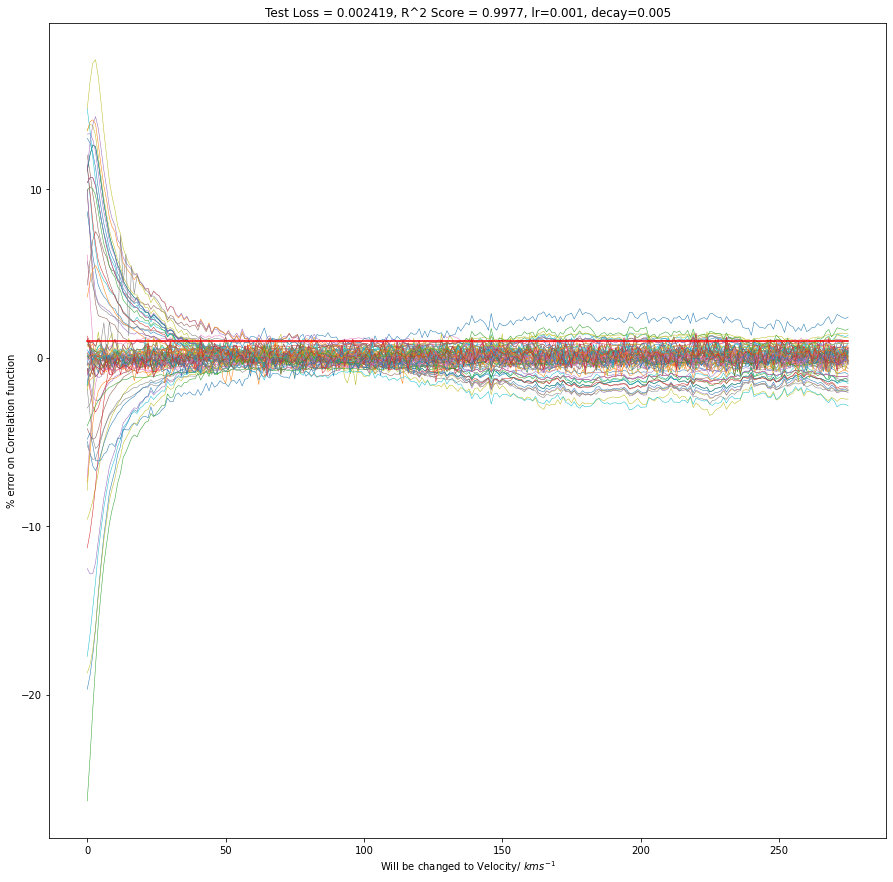

Test MSE Loss: 0.0024194641944462114

Test R^2 Score: 0.9977496115537126

accuracy: 0.00014876697376341367
(0,)


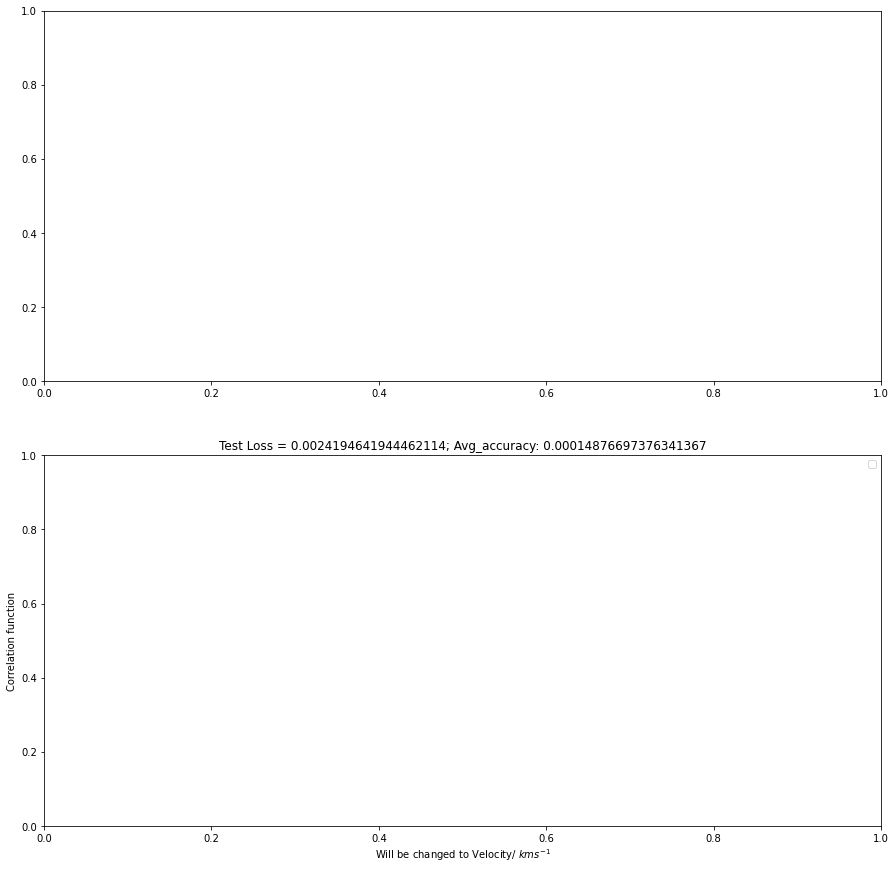

In [40]:

    # Plot relative error of all test correlation functions
    delta = np.asarray(accuracy(params, X_test, Y_test))
    new_delta = delta
'''    
    c = 0
    new_delta = np.zeros(delta.shape)
    for i, d in enumerate(delta):
        for j, e in enumerate(d):
            if e > 5:
                c=+1
        if c == 0:
            new_delta[i]=d
            c=0
    print(new_delta.shape)          
'''
    plt.figure(figsize=(15, 15))
    for i in range(new_delta.shape[0]):
        plt.plot(np.arange(276),new_delta[i,:]*100, linewidth=0.5)
    plt.plot(np.arange(276),jnp.ones([276]),c='r')
    plt.xlabel(r'Will be changed to Velocity/ $km s^{-1}$')
    plt.ylabel('% error on Correlation function')
    plt.title(f'Test Loss = {test_loss:.6f}, R^2 Score = {test_R2:.4f}, lr={lr}, decay={decay}')
    dir_exp = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/EXP/'  # plot saving directory
#plt.savefig(os.path.join(dir_exp, f'{self.layers}_test%error{self.comment}.png'))
    plt.show()

    print("Test MSE Loss: {}\n".format(test_loss)) # Loss
    print('Test R^2 Score: {}\n'.format(test_R2))  # R^2 score: ranging 0~1, 1 is good model
    print(f'accuracy: {jnp.mean(delta)}')
    
    unlearnt_idx = []
    for i, d in enumerate(delta):
        for j, e in enumerate(d):
            if e > 5:
                unlearnt_idx.append(i)
                break
    unlearnt_idx = jnp.asarray(unlearnt_idx)
    print(unlearnt_idx.shape)
    
    fig2, axs2 = plt.subplots(2, 1)
    fig2.set_figwidth(15)
    fig2.set_figheight(15)
    for i in range(unlearnt_idx.shape[0]):
        axs2[0].plot(ax, test_preds[unlearnt_idx[i]], label=f'Preds {i}:' r'$<F>$='f'{X_test[unlearnt_idx[i], 0]:.2f},'
                                               r'$T_0$='f'{X_test[unlearnt_idx[i], 1]:.2f},'
                                               r'$\gamma$='f'{X_test[unlearnt_idx[i], 2]:.2f}', c=f'C{i}', alpha=0.3,linestyle='-.')
        axs2[0].plot(ax, Y_test[unlearnt_idx[i]], label=f'Real {i}', c=f'C{i}', linestyle='--')
        axs2[1].plot(ax, new_delta[unlearnt_idx[i],:],c=f'C{i}',label=f'%{i}',linewidth=0.6)
    # axs.plot(ax, y_mean, label='Y mean', c='k', alpha=0.2)
    plt.xlabel(r'Will be changed to Velocity/ $km s^{-1}$')
    plt.ylabel('Correlation function')
    plt.title(f'Test Loss = {test_loss}; Avg_accuracy: {jnp.mean(delta)}')
    plt.legend()
    dir_exp = '/home/zhenyujin/igm_emulator/igm_emulator/emulator/EXP/'  # plot saving directory
    # plt.savefig(os.path.join(dir_exp, f'{self.layers}_overplot{self.comment}.png'))
    plt.show()

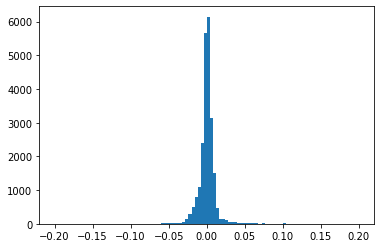

In [41]:
plt.hist(new_delta.flatten(),bins=100,range=[-0.2,0.2])
plt.show()

In [42]:
print(f'mean: {np.mean(new_delta)}; std: {np.std(new_delta)}')

mean: 0.00014876697376341397; std: 0.014249682717543753
